## Compare different baselines for MHW detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as cmo

import cartopy.crs as ccrs
import cartopy.feature as cft
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [2]:
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

In [3]:
import dask, dask_jobqueue 
import dask.distributed as dask_distributed

cluster = dask_jobqueue.SLURMCluster(
        # Dask worker size
        cores=32, memory='80GB',
        processes=4, # Dask workers per job
       # SLURM job script things
        queue='base', walltime='03:00:00',
        # Dask worker network and temporary
        interface='ib0', local_directory='./dask_jobqueue_logs'
        )

client = dask_distributed.Client(cluster)
cluster.scale(jobs=1)


/gxfs_work/geomar/smomw379/miniconda3/envs/py3_mhw/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37231 instead
  warnings.warn(


In [5]:
!squeue -u smomw379

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          15908298      base dask-wor smomw379  R       0:37      1 nesh-clk494
          15908160      base dask-wor smomw379  R      31:01      1 nesh-srp139


In [6]:
client

<Client: 'tcp://172.18.4.23:45879' processes=4 threads=32, memory=74.52 GiB>

## load files 

In [7]:
## load mask: nest
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003/'
mask = xr.open_dataset(path+'1_atlantic_mask_3D.nc').squeeze()
land_mask = mask.tmask.rename({'X':'x','Y':'y','z':'deptht'})

path ='/gxfs_work/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/suppl/1_mesh_mask.nc'
dsM = xr.open_dataset(path).squeeze().rename({'z':'deptht'})

In [8]:
## load mask: host
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003/'
mask = xr.open_dataset(path+'atlantic_mask_3D.nc').squeeze()
land_maskO = mask.tmask.isel(X=range(750,1250)).rename({'X':'x','Y':'y','z':'deptht'})

path ='/gxfs_work/geomar/smomw355/model_data/ocean-only/ORCA025.L46-KFS006-P-V/nemo/suppl/mesh_mask.nc'
dsMO = xr.open_dataset(path).squeeze().isel(x=range(750,1250)).rename({'z':'deptht'})

## only atlantic and mask land values based on native ORCA025 grid
maskO = (land_maskO*dsMO.tmask)
maskO[:,852:,:] = 0 ## remove atlantic points outside nest domain
maskO[:,0:353,:] = 0 

A = (dsMO.e1t * dsMO.e2t).where(maskO == 1).compute()

In [9]:
def load_stats(EXP, baseline, var):
    path = f'/gxfs_work/geomar/smomw379/DATA/{EXP}/MHW_Detection/ANALYSIS/'
    ds_00 = xr.open_dataset(path+f'{EXP}_1y_19800101_20221231_{var}-{baseline}-00.nc')
    ds_10 = xr.open_dataset(path+f'{EXP}_1y_19800101_20221231_{var}-{baseline}-10.nc')
    ds_23 = xr.open_dataset(path+f'{EXP}_1y_19800101_20221231_{var}-{baseline}-23.nc')
    ds_30 = xr.open_dataset(path+f'{EXP}_1y_19800101_20221231_{var}-{baseline}-30.nc')

    return ds_00, ds_10, ds_23, ds_30

In [10]:
## Detrend 
# cycle 1
dsB1_D_00_detr, dsB1_D_10_detr, dsB1_D_23_detr, dsB1_D_30_detr = load_stats('VIKING20X.L46-KFS003', 'detrend', 'MHW-days')

# cycle 6
dsB6_D_00_detr, dsB6_D_10_detr, dsB6_D_23_detr, dsB6_D_30_detr = load_stats('VIKING20X.L46-KFS003-6th', 'detrend', 'MHW-days')


In [11]:
## Fixed 
# cycle 1
dsB1_D_00_fix, dsB1_D_10_fix, dsB1_D_23_fix, dsB1_D_30_fix = load_stats('VIKING20X.L46-KFS003', 'fixed', 'MHW-days')

# cycle 6
dsB6_D_00_fix, dsB6_D_10_fix, dsB6_D_23_fix, dsB6_D_30_fix = load_stats('VIKING20X.L46-KFS003-6th', 'fixed', 'MHW-days')

In [12]:
## Non-linear 
# cycle 1
dsB1_D_00_non, dsB1_D_10_non, dsB1_D_23_non, dsB1_D_30_non = load_stats('VIKING20X.L46-KFS003', 'non-linear', 'MHW-days')

# cycle 6
dsB6_D_00_non, dsB6_D_10_non, dsB6_D_23_non, dsB6_D_30_non = load_stats('VIKING20X.L46-KFS003-6th', 'non-linear', 'MHW-days')

In [13]:
## WMO
# cycle 1
dsB1_D_00_WMO, dsB1_D_10_WMO, dsB1_D_23_WMO, dsB1_D_30_WMO = load_stats('VIKING20X.L46-KFS003', 'WMO', 'MHW-days')

# cycle 6
dsB6_D_00_WMO, dsB6_D_10_WMO, dsB6_D_23_WMO, dsB6_D_30_WMO = load_stats('VIKING20X.L46-KFS003-6th', 'WMO', 'MHW-days')


In [14]:
## define time axis
time = np.arange(1980,2023)

## all atlantic

In [15]:
def area_average_D(dsD, A):
    ## area average: weigh by grid cell area so that subpolar latitudes have no larger contribution as there are more, but smaller grid points
    ## ignore grid points where no heatwaves occured for event based averages (duration, intensity)
    ## don't ignore them for grid point based averages (MHW days per year and Events per year)

    Area_averageD =  (dsD * A).sum(('x','y')) / A.sum(('x','y'))

    return Area_averageD

In [16]:
## surface

MHW_domain_B1_00_detr = area_average_D(dsB1_D_00_detr.N_MHW_days, A.isel(deptht=0))
MHW_domain_B1_00_fix  = area_average_D(dsB1_D_00_fix.N_MHW_days, A.isel(deptht=0)) 
MHW_domain_B1_00_non  = area_average_D(dsB1_D_00_non.N_MHW_days, A.isel(deptht=0))  
MHW_domain_B1_00_WMO = area_average_D(dsB1_D_00_WMO.N_MHW_days, A.isel(deptht=0))

MHW_domain_B6_00_detr = area_average_D(dsB6_D_00_detr.N_MHW_days, A.isel(deptht=0))
MHW_domain_B6_00_fix  = area_average_D(dsB6_D_00_fix.N_MHW_days, A.isel(deptht=0)) 
MHW_domain_B6_00_non  = area_average_D(dsB6_D_00_non.N_MHW_days, A.isel(deptht=0))  
MHW_domain_B6_00_WMO = area_average_D(dsB6_D_00_WMO.N_MHW_days, A.isel(deptht=0))

In [17]:
## 100 m

MHW_domain_B1_10_detr = area_average_D(dsB1_D_10_detr.N_MHW_days, A.isel(deptht=10))
MHW_domain_B1_10_fix  = area_average_D(dsB1_D_10_fix.N_MHW_days, A.isel(deptht=10)) 
MHW_domain_B1_10_non  = area_average_D(dsB1_D_10_non.N_MHW_days, A.isel(deptht=10))  
MHW_domain_B1_10_WMO = area_average_D(dsB1_D_10_WMO.N_MHW_days, A.isel(deptht=10))

MHW_domain_B6_10_detr = area_average_D(dsB6_D_10_detr.N_MHW_days, A.isel(deptht=10))
MHW_domain_B6_10_fix  = area_average_D(dsB6_D_10_fix.N_MHW_days, A.isel(deptht=10)) 
MHW_domain_B6_10_non  = area_average_D(dsB6_D_10_non.N_MHW_days, A.isel(deptht=10))  
MHW_domain_B6_10_WMO = area_average_D(dsB6_D_10_WMO.N_MHW_days, A.isel(deptht=10))

In [18]:
## 1000 m

MHW_domain_B1_23_detr = area_average_D(dsB1_D_23_detr.N_MHW_days, A.isel(deptht=23))
MHW_domain_B1_23_fix  = area_average_D(dsB1_D_23_fix.N_MHW_days, A.isel(deptht=23)) 
MHW_domain_B1_23_non  = area_average_D(dsB1_D_23_non.N_MHW_days, A.isel(deptht=23))  
MHW_domain_B1_23_WMO = area_average_D(dsB1_D_23_WMO.N_MHW_days, A.isel(deptht=23))

MHW_domain_B6_23_detr = area_average_D(dsB6_D_23_detr.N_MHW_days, A.isel(deptht=23))
MHW_domain_B6_23_fix  = area_average_D(dsB6_D_23_fix.N_MHW_days, A.isel(deptht=23)) 
MHW_domain_B6_23_non  = area_average_D(dsB6_D_23_non.N_MHW_days, A.isel(deptht=23))  
MHW_domain_B6_23_WMO = area_average_D(dsB6_D_23_WMO.N_MHW_days, A.isel(deptht=23))

In [19]:
## 2200 m

MHW_domain_B1_30_detr = area_average_D(dsB1_D_30_detr.N_MHW_days, A.isel(deptht=30))
MHW_domain_B1_30_fix  = area_average_D(dsB1_D_30_fix.N_MHW_days, A.isel(deptht=30)) 
MHW_domain_B1_30_non  = area_average_D(dsB1_D_30_non.N_MHW_days, A.isel(deptht=30))  
MHW_domain_B1_30_WMO = area_average_D(dsB1_D_30_WMO.N_MHW_days, A.isel(deptht=30))

MHW_domain_B6_30_detr = area_average_D(dsB6_D_30_detr.N_MHW_days, A.isel(deptht=30))
MHW_domain_B6_30_fix  = area_average_D(dsB6_D_30_fix.N_MHW_days, A.isel(deptht=30)) 
MHW_domain_B6_30_non  = area_average_D(dsB6_D_30_non.N_MHW_days, A.isel(deptht=30))  
MHW_domain_B6_30_WMO = area_average_D(dsB6_D_30_WMO.N_MHW_days, A.isel(deptht=30))

## Depth profiles

In [20]:
## load mask: host
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003/'
mask = xr.open_dataset(path+'atlantic_mask_3D.nc').squeeze()
ATLmask = mask.tmask.isel(X=range(750,1250),z=0).rename({'X':'x','Y':'y'})
ATLmask[852:,:] = 0 ## remove atlantic points outside nest domain
ATLmask[0:353,:] = 0 

path ='/gxfs_work/geomar/smomw355/model_data/ocean-only/ORCA025.L46-KFS006-P-V/nemo/suppl/mesh_mask.nc'
dsM = xr.open_dataset(path).squeeze().isel(x=range(750,1250)).rename({'z':'deptht'})

N_gridcells = np.nansum((dsM.tmask * ATLmask.values), axis=(1,2))

dpt = -dsM.nav_lev[0:25]

In [21]:
## grid cell area
A = (dsM.e1t * dsM.e2t).where(ATLmask==1).compute()

In [22]:
def area_average(dsD, zz, allATL=True, xR=None, yR=None):
    ## area average: weigh by grid cell area so that subpolar latitudes have no larger contribution as there are more, but smaller grid points
    ## ignore grid points where no heatwaves occured for event based averages (duration, intensity)
    ## don't ignore them for grid point based averages (MHW days per year and Events per year)
    
    if allATL:
        Area_averageD =  (dsD.where((ATLmask==1)) * A).sum(('x','y')) / A.where(dsM.tmask.isel(deptht=zz) == 1).sum(('x','y'))
    else:
        Area_averageD =  (dsD.where((ATLmask==1)) * A).isel(x=xR,y=yR).sum(('x','y')) / A.where(dsM.tmask.isel(deptht=zz) == 1).isel(x=xR,y=yR).sum(('x','y'))

    return Area_averageD

In [23]:
## set subregions
xLS = range(200,225); yLS = range(760,790) # Labrador Sea
yTR = range(554,575); xTR = range(295,312) # Cape Verde region

In [24]:
## depth profiles
MHW_days_z_d6 = np.zeros((25));  MHW_days_z_W6 = np.zeros((25)); MHW_days_z_d1 = np.zeros((25));  MHW_days_z_W1 = np.zeros((25))

for zz in range(0,25):

    if zz < 10:
        z = f'0{zz}'
    else:
        z=str(zz)

    ## load data
    path ='/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/MHW_Detection/ANALYSIS/'
    dsD_d6 = xr.open_dataset(path+f'VIKING20X.L46-KFS003-6th_1y_19800101_20221231_MHW-days-detrend-{z}.nc').N_MHW_days
    dsD_W6 = xr.open_dataset(path+f'VIKING20X.L46-KFS003-6th_1y_19800101_20221231_MHW-days-WMO-{z}.nc').N_MHW_days


    path ='/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003/MHW_Detection/ANALYSIS/'
    dsD_d1 = xr.open_dataset(path+f'VIKING20X.L46-KFS003_1y_19800101_20221231_MHW-days-detrend-{z}.nc').N_MHW_days
    dsD_W1 = xr.open_dataset(path+f'VIKING20X.L46-KFS003_1y_19800101_20221231_MHW-days-WMO-{z}.nc').N_MHW_days


    ## area-average
    Area_averageD_d6 = area_average(dsD_d6, zz)
    Area_averageD_W6 = area_average(dsD_W6, zz)
    Area_averageD_d1 = area_average(dsD_d1, zz)
    Area_averageD_W1 = area_average(dsD_W1, zz)

    ## Difference between first and last decade
    MHW_days_z_d6[zz]  = Area_averageD_d6[-10:].mean('time') - Area_averageD_d6[0:10].mean('time')
    MHW_days_z_W6[zz]  = Area_averageD_W6[-10:].mean('time') - Area_averageD_W6[0:10].mean('time')
    MHW_days_z_d1[zz]  = Area_averageD_d1[-10:].mean('time') - Area_averageD_d1[0:10].mean('time')
    MHW_days_z_W1[zz]  = Area_averageD_W1[-10:].mean('time') - Area_averageD_W1[0:10].mean('time')



In [25]:
## depth profiles
MHW_days_z_d6_LS = np.zeros((25));  MHW_days_z_W6_LS = np.zeros((25)); MHW_days_z_d1_LS = np.zeros((25));  MHW_days_z_W1_LS = np.zeros((25))


for zz in range(0,25):

    if zz < 10:
        z = f'0{zz}'
    else:
        z=str(zz)

    ## load data
    path ='/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/MHW_Detection/ANALYSIS/'
    dsD_d6 = xr.open_dataset(path+f'VIKING20X.L46-KFS003-6th_1y_19800101_20221231_MHW-days-detrend-{z}.nc').N_MHW_days
    dsD_W6 = xr.open_dataset(path+f'VIKING20X.L46-KFS003-6th_1y_19800101_20221231_MHW-days-WMO-{z}.nc').N_MHW_days

    path ='/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003/MHW_Detection/ANALYSIS/'
    dsD_d1 = xr.open_dataset(path+f'VIKING20X.L46-KFS003_1y_19800101_20221231_MHW-days-detrend-{z}.nc').N_MHW_days
    dsD_W1 = xr.open_dataset(path+f'VIKING20X.L46-KFS003_1y_19800101_20221231_MHW-days-WMO-{z}.nc').N_MHW_days

    ## LabSea 
    Area_averageD_d6_LS = area_average(dsD_d6, zz, allATL=False, xR=xLS, yR=yLS)
    Area_averageD_W6_LS = area_average(dsD_W6, zz, allATL=False, xR=xLS, yR=yLS)
    Area_averageD_d1_LS = area_average(dsD_d1, zz, allATL=False, xR=xLS, yR=yLS)
    Area_averageD_W1_LS = area_average(dsD_W1, zz, allATL=False, xR=xLS, yR=yLS)


    MHW_days_z_d6_LS[zz]  = Area_averageD_d6_LS[-10:].mean('time') - Area_averageD_d6_LS[0:10].mean('time')
    MHW_days_z_W6_LS[zz]  = Area_averageD_W6_LS[-10:].mean('time') - Area_averageD_W6_LS[0:10].mean('time')
    MHW_days_z_d1_LS[zz]  = Area_averageD_d1_LS[-10:].mean('time') - Area_averageD_d1_LS[0:10].mean('time')
    MHW_days_z_W1_LS[zz]  = Area_averageD_W1_LS[-10:].mean('time') - Area_averageD_W1_LS[0:10].mean('time')

In [26]:
## depth profiles
MHW_days_z_d6_TR = np.zeros((25));  MHW_days_z_W6_TR = np.zeros((25)); MHW_days_z_d1_TR = np.zeros((25));  MHW_days_z_W1_TR = np.zeros((25))

for zz in range(0,25):

    if zz < 10:
        z = f'0{zz}'
    else:
        z=str(zz)

    ## load data
    path ='/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/MHW_Detection/ANALYSIS/'
    dsD_d6 = xr.open_dataset(path+f'VIKING20X.L46-KFS003-6th_1y_19800101_20221231_MHW-days-detrend-{z}.nc').N_MHW_days
    dsD_W6 = xr.open_dataset(path+f'VIKING20X.L46-KFS003-6th_1y_19800101_20221231_MHW-days-WMO-{z}.nc').N_MHW_days

    path ='/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003/MHW_Detection/ANALYSIS/'
    dsD_d1 = xr.open_dataset(path+f'VIKING20X.L46-KFS003_1y_19800101_20221231_MHW-days-detrend-{z}.nc').N_MHW_days
    dsD_W1 = xr.open_dataset(path+f'VIKING20X.L46-KFS003_1y_19800101_20221231_MHW-days-WMO-{z}.nc').N_MHW_days

    ## Tropical Atlantic (Cape Verde archipelago) 
    Area_averageD_d6_TR = area_average(dsD_d6, zz, allATL=False, xR=xTR, yR=yTR)
    Area_averageD_W6_TR = area_average(dsD_W6, zz, allATL=False, xR=xTR, yR=yTR)
    Area_averageD_d1_TR = area_average(dsD_d1, zz, allATL=False, xR=xTR, yR=yTR)
    Area_averageD_W1_TR = area_average(dsD_W1, zz, allATL=False, xR=xTR, yR=yTR)


    MHW_days_z_d6_TR[zz]  = Area_averageD_d6_TR[-10:].mean('time') - Area_averageD_d6_TR[0:10].mean('time')
    MHW_days_z_W6_TR[zz]  = Area_averageD_W6_TR[-10:].mean('time') - Area_averageD_W6_TR[0:10].mean('time')
    MHW_days_z_d1_TR[zz]  = Area_averageD_d1_TR[-10:].mean('time') - Area_averageD_d1_TR[0:10].mean('time')
    MHW_days_z_W1_TR[zz]  = Area_averageD_W1_TR[-10:].mean('time') - Area_averageD_W1_TR[0:10].mean('time')


In [27]:
props = dict(boxstyle='round', facecolor='silver', alpha=0.5)

/tmp/ipykernel_804044/1649797643.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(np.arange(0,100,20))
/tmp/ipykernel_804044/1649797643.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_yticklabels(np.arange(0,200,50))
/tmp/ipykernel_804044/1649797643.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_yticklabels(np.arange(0,400,100))


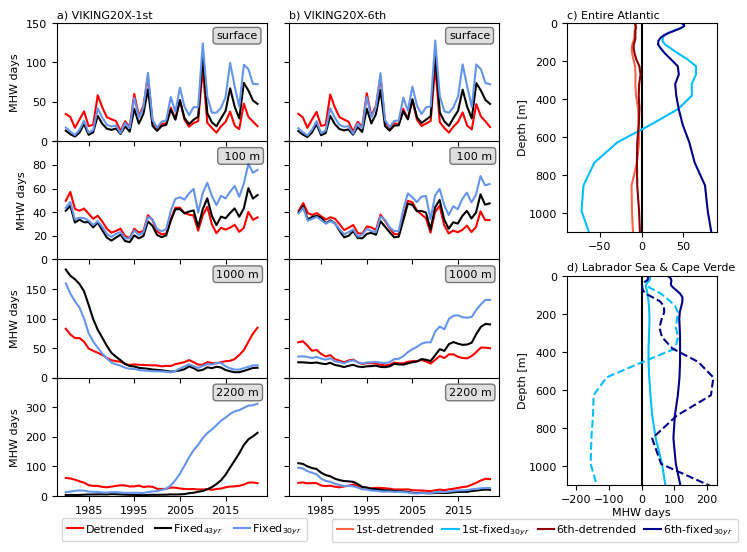

In [85]:
fig = plt.figure(figsize=(7.5,5.5))
ax1 = fig.add_axes([0.07,0.735,0.28,0.215],zorder=50)
ax2 = fig.add_axes([0.07,0.52,0.28,0.215],zorder=40); ax2.spines[['top']].set_visible(False)
ax3 = fig.add_axes([0.07,0.305,0.28,0.215],zorder=30); ax3.spines[['top']].set_visible(False)
ax4 = fig.add_axes([0.07,0.09,0.28,0.215],zorder=20); ax4.spines[['top']].set_visible(False)

ax5 = fig.add_axes([0.38,0.735,0.28,0.215],zorder=50); 
ax6 = fig.add_axes([0.38,0.52,0.28,0.215],zorder=40); ax6.spines[['top']].set_visible(False)
ax7 = fig.add_axes([0.38,0.305,0.28,0.215],zorder=30); ax7.spines[['top']].set_visible(False)
ax8 = fig.add_axes([0.38,0.09,0.28,0.215],zorder=20); ax8.spines[['top']].set_visible(False)

ax9 = fig.add_axes([0.75, 0.57, 0.2, 0.38])
ax10 = fig.add_axes([0.75, 0.11, 0.2, 0.38])

######
## surface
ax1.plot(time, MHW_domain_B1_00_detr, color='r')
ax1.plot(time, MHW_domain_B1_00_fix, color='k')
ax1.plot(time, MHW_domain_B1_00_WMO, color='cornflowerblue')

ax1.set_xticks(np.arange(1985,2020,10)); ax1.set_xticklabels([])
ax1.set_ylabel('MHW days', fontsize=8)
ax1.set_title('a) VIKING20X-1st', loc='left', fontsize=8, pad=4)
ax1.set_ylim(0,150)
ax1.set_xlim(1978,2024)
ax1.text(2013,130,'surface', fontsize=8, bbox=props)

## 100m
ax2.plot(time, MHW_domain_B1_10_detr, color='r')
ax2.plot(time, MHW_domain_B1_10_fix, color='k')
ax2.plot(time, MHW_domain_B1_10_WMO, color='cornflowerblue')

ax2.set_xticks(np.arange(1985,2020,10)); ax2.set_xticklabels([])
ax2.set_ylim(0,100)
ax2.set_xlim(1978,2024)
ax2.text(2014,85,' 100 m',fontsize=8, bbox=props)
ax2.set_ylabel('MHW days', fontsize=8)
ax2.set_yticklabels(np.arange(0,100,20))

## 1000m
ax3.plot(time, MHW_domain_B1_23_detr, color='r')
ax3.plot(time, MHW_domain_B1_23_fix, color='k')
ax3.plot(time, MHW_domain_B1_23_WMO, color='cornflowerblue')

ax3.set_xticks(np.arange(1985,2020,10)); ax3.set_xticklabels([])
ax3.set_ylim(0,200)
ax3.text(2013,170,'1000 m',fontsize=8, bbox=props)
ax3.set_ylabel('MHW days', fontsize=8)
ax3.set_xlim(1978,2024)
ax3.set_yticklabels(np.arange(0,200,50))

## 2200m
ax4.plot(time, MHW_domain_B1_30_detr, color='r', label='Detrended')
ax4.plot(time, MHW_domain_B1_30_fix, color='k', label=r'Fixed$_{43yr}$')
ax4.plot(time, MHW_domain_B1_30_WMO, color='cornflowerblue', label=r'Fixed$_{30yr}$')

ax4.set_yticklabels(np.arange(0,400,100))
ax4.set_xticks(np.arange(1985,2020,10))
ax4.set_ylim(0,400)
ax4.text(2013,340,'2200 m',fontsize=8, bbox=props)
ax4.set_ylabel('MHW days', fontsize=8)
ax4.set_xlim(1978,2024)
ax4.legend(ncol=4, fontsize=8, loc='lower left', bbox_to_anchor=[0,-0.43], handlelength=1.5, columnspacing=0.9, handletextpad=0.2)

######
## surface
ax5.plot(time, MHW_domain_B6_00_detr, color='r')
ax5.plot(time, MHW_domain_B6_00_fix, color='k')
ax5.plot(time, MHW_domain_B6_00_WMO, color='cornflowerblue')

ax5.set_ylim(0,150)
ax5.set_yticklabels([])
ax5.set_xticks(np.arange(1985,2020,10)); ax5.set_xticklabels([])
ax5.set_title('b) VIKING20X-6th', loc='left', fontsize=8, pad=4)
ax5.set_xlim(1978,2024)
ax5.text(2013,130,'surface', fontsize=8, bbox=props)

## 100m
ax6.plot(time, MHW_domain_B6_10_detr, color='r')
ax6.plot(time, MHW_domain_B6_10_fix, color='k')

ax6.plot(time, MHW_domain_B6_10_WMO, color='cornflowerblue')
ax6.set_ylim(0,100)
ax6.set_yticklabels([])
ax6.set_xticks(np.arange(1985,2020,10)); ax6.set_xticklabels([])
ax6.text(2014,85,' 100 m',fontsize=8, bbox=props)

## 1000m
ax7.plot(time, MHW_domain_B6_23_detr, color='r')
ax7.plot(time, MHW_domain_B6_23_fix, color='k')
ax7.plot(time, MHW_domain_B6_23_WMO, color='cornflowerblue')

ax7.set_ylim(0,200)
ax7.set_yticklabels([])
ax7.set_xticks(np.arange(1985,2020,10)); ax7.set_xticklabels([])
ax7.text(2013,170,'1000 m',fontsize=8, bbox=props)
ax7.set_xlim(1978,2024)

## 2200m

ax8.plot(time, MHW_domain_B6_30_detr, color='r')
ax8.plot(time, MHW_domain_B6_30_fix, color='k')
ax8.plot(time, MHW_domain_B6_30_WMO, color='cornflowerblue')

ax8.set_ylim(0,400)
ax8.set_xticks(np.arange(1985,2020,10));
ax8.set_yticklabels([])
ax8.text(2013,340,'2200 m',fontsize=8, bbox=props)
ax8.set_xlim(1978,2024)

### Profiles 

## entire Atlantic 
ax9.plot(MHW_days_z_d1, dpt, 'tomato', label='1st-detrended')
ax9.plot(MHW_days_z_W1, dpt, 'deepskyblue', label=r'1st-fixed$_{30yr}$')
ax9.plot(MHW_days_z_d6, dpt, 'darkred', label='6th-detrended')
ax9.plot(MHW_days_z_W6, dpt, 'darkblue', label=r'6th-fixed$_{30yr}$')

ax9.vlines(0,-1100,0, colors='k', linestyles='-', zorder=0)
ax9.set_ylim(-1100,0)
ax9.set_yticks(np.arange(-1000,1,200)); ax9.set_yticklabels(np.arange(1000,-1,-200))
ax9.set_xlim(-90,90)
ax9.set_ylabel('Depth [m]', fontsize=8, labelpad=0)
ax9.set_title('c) Entire Atlantic', fontsize=8, loc='left', pad=4)

ax9.legend(fontsize=8, ncol=4, loc='lower left', bbox_to_anchor=[-1.6,-1.51], handlelength=1.5, columnspacing=0.7, handletextpad=0.2)

## regional
ax10.plot(MHW_days_z_W1_LS, dpt, 'deepskyblue', label=r'VIKING20X-1st-fixed$_{30yr}$')
ax10.plot(MHW_days_z_W1_TR, dpt, 'deepskyblue', linestyle='--')
ax10.plot(MHW_days_z_W6_LS, dpt, 'darkblue', label=r'VIKING20X-6th-fixed$_{30yr}$')
ax10.plot(MHW_days_z_W6_TR, dpt, 'darkblue', linestyle='--')

ax10.vlines(0,-1100,0, colors='k', linestyles='-', zorder=0)
ax10.set_ylim(-1100,0)
ax10.set_xlim(-230,230); ax10.set_xticks(np.arange(-200,201,100))
ax10.set_yticks(np.arange(-1000,1,200)); ax10.set_yticklabels(np.arange(1000,-1,-200))
ax10.set_xlabel('MHW days', fontsize=8, labelpad=2)
ax10.set_ylabel('Depth [m]', fontsize=8, labelpad=0)
ax10.set_title('d) Labrador Sea & Cape Verde', fontsize=8, loc='left', pad=4)


plt.savefig('Baselines-tseries.png', dpi=300)

In [31]:
## correlations between 1st and 6th cycle
print('WMO baseline')
print('0m    ', np.corrcoef(MHW_domain_B1_00_WMO,MHW_domain_B6_00_WMO)[0,1])
print('100m  ', np.corrcoef(MHW_domain_B1_10_WMO,MHW_domain_B6_10_WMO)[0,1])
print('1000m ', np.corrcoef(MHW_domain_B1_23_WMO,MHW_domain_B6_23_WMO)[0,1])
print('2200m ', np.corrcoef(MHW_domain_B1_30_WMO,MHW_domain_B6_30_WMO)[0,1])
##
print('Linear baseline')
print('0m    ', np.corrcoef(MHW_domain_B1_00_detr,MHW_domain_B6_00_detr)[0,1])
print('100m  ', np.corrcoef(MHW_domain_B1_10_detr,MHW_domain_B6_10_detr)[0,1])
print('1000m ', np.corrcoef(MHW_domain_B1_23_detr,MHW_domain_B6_23_detr)[0,1])
print('2200m ', np.corrcoef(MHW_domain_B1_30_detr,MHW_domain_B6_30_detr)[0,1])
##
print('Fixed baseline')
print('0m    ', np.corrcoef(MHW_domain_B1_00_fix,MHW_domain_B6_00_fix)[0,1])
print('100m  ', np.corrcoef(MHW_domain_B1_10_fix,MHW_domain_B6_10_fix)[0,1])
print('1000m ', np.corrcoef(MHW_domain_B1_23_fix,MHW_domain_B6_23_fix)[0,1])
print('2200m ', np.corrcoef(MHW_domain_B1_30_fix,MHW_domain_B6_30_fix)[0,1])

WMO baseline
0m     0.9994963931604558
100m   0.982820265929748
1000m  -0.2389772279744718
2200m  -0.3700810006057262
Linear baseline
0m     0.9992629893624113
100m   0.9414339387650124
1000m  0.9128631548403052
2200m  0.8516569436222504
Fixed baseline
0m     0.9991404169465722
100m   0.9642094349045888
1000m  -0.2748326729338303
2200m  -0.29828996159724425


## Save data for publication
* full output (annual mean MHW characteristics) already stored 